<font size=6  > [LINMA 2472] - ALGORITHMS IN DATA SCIENCE <br><br> 
HW 2 (Part I): k-PCA for outlier detection!   </font> <br><br><br>

<font size=5  >


<br><br>
Loïc Van Hoorebeeck [LVH]  (loic.vanhoorebeeck@uclouvain.be)<br> <br>
<div style="text-align: right"> Version 1 (2021-10-27)</div>

<br><br>
</font>

<br>

<font size=7 color=#009999> Assignment 1. PCA vs. k-PCA <br><br> for outlier detection </font> <br>

<br>
<font size=5 color=#009999> Contex </font> <br>

In this assignment, you are asked to compare PCA vs. KPCA (or k-PCA) for outlier detection. We define an outlier as any point sampled from another distribution than the one we are interested in.



<font size=5 color=#009999> Instruction </font> <br>

You should fill the jupyter notebook, and write a written report that answers the questions from the pdf file.

You have to submit <b> 3 </b> files on moodle:

    - Your jupyter notebook as .ipynb 
    - Your jupyter notebook (with all output, that is after running everything) as .pdf
    - Your written report as .pdf
    
Note that we filled the notebook such that it runs without throwing errors... But we had to sometimes write dummy lines, which implies that the plots look also dummy.

When you have to modify something in the code, you'll find a "TODO" mark.

</font>

In [ ]:
#Various import

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt


# When developping code, it is often easier to work with a fixed seed
np.random.seed(42)




<font size=5 color=#009999> Q1. IMPORT THE DATA and perform EDA</font> <br>

The data consists in two arrays $X \in \mathbb{R}^{N \times 2}$ and $\mathbf{y} \in \mathbb{R}^{N}$ with

$$
y_i =
\begin{cases}
    1 & \text{ if } & \mathbf{X}_{i, *} & \text{ is an outlier,}\\
    0 & \text{ if } & \mathbf{X}_{i, *} & \text{ is a true point.}
\end{cases}
$$

with $N$ the number of samples. There are $N_o$ outliers and $N_t$ *true* point, that is $N_t$ points that are not outliers.



In [ ]:
# Import of the data

X = np.loadtxt('X.txt')
y = np.loadtxt('y.txt').astype(int)

# TODO
N=y.shape[0]
N_o= np.count_nonzero(y)
N_t=N-N_o

print(f" Our data has {N_t} true points and {N_o} outliers \n Outlier ratio r={N_o/N}")

 Our data has 400 true points and 100 outliers 
 Outlier ratio r=0.2


In [ ]:
#Split point in true points matrix X_t of shape (N_t,2) and outlier points matrix X_o of shape (N_o,2)
X_t=np.zeros((N_t,2))
X_o=np.zeros((N_o,2))
i_o=i_t=0
for i in range(X.shape[0]):
  if (y[i]==0):
    X_t[i_t,:]=X[i,:]
    i_t+=1
  if (y[i]==1):
    X_o[i_o,:]=X[i,:]
    i_o+=1

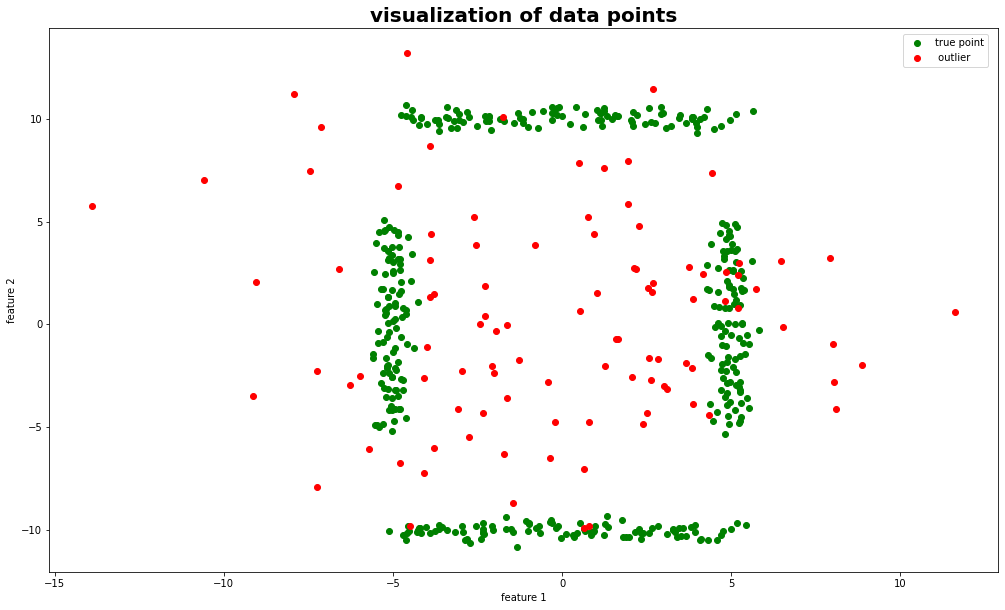

In [ ]:
fig=plt.figure(figsize=(17,10))
plt.scatter(X_t[:,0],X_t[:,1],color="green",label="true point")
plt.scatter(X_o[:,0],X_o[:,1],color="red", label=" outlier")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(bbox_to_anchor=(0.99, 0.99), borderaxespad=0.)

plt.title("visualization of data points",fontweight="bold",fontsize=20)
plt.show()







## <font size=5 color=#009999> Q2. Perform the splits </font> <br>

</font>

No need to reimplent the wheel: use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html'><code>train_test_split</code></a> from sklearn to perform the splits.

In [ ]:

X_train = X
X_val = X
X_test = X

y_train = X
y_val = X
y_test = X

# TODO

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True)
X_train,X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.3, shuffle=True)

print(f" we have {X_train.shape[0]} training points, {X_val.shape[0]} validation points and {X_test.shape[0]} test points")

 we have 315 training points, 135 validation points and 50 test points


## <font size=5 color=#009999> Q3. PCA </font> <br>
</font>

Let us implement an outlier detector using PCA. In order to make our life easier, we will create a class, denoted as <code>OutlierDetectorPCA</code>, that inherits from other classes of <code>sklearn</code>.

We implemented most of the class, but there are some parts missing...

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

plt.rcParams['figure.figsize'] = [20, 10]


class OutlierDetectorPCA(BaseEstimator, ClassifierMixin):
    def __init__(self, k):
        """ ------------------------------------------------------------------------------
        Class constructor
        INPUT:
            - k: the number of eigenvectors that we keep, or equivalently, the size of the
                 the eigen (sub)space.
        ------------------------------------------------------------------------------ """
        self.k = k
        self.is_fitted_ = False
        self.pca = PCA()
        self.name = 'PCA'
        self.pca = PCA()
        self.tau = np.inf

  
    def _get_recons_error(self, X, X_hat):
        """ ------------------------------------------------------------------------------
        Compute the reconstruction error between X and X_hat, where X_hat is the projection 
        of X onto the k-dimensional eigenspace
        INPUT: 
            - X: initial features
            - X_hat: projected features
        OUTPUT:
            - recons_error: the reconstruction error
        ------------------------------------------------------------------------------ """
        # recons matrix 
        recons_error = np.ones(X.shape[0])
        rec=[]
        for i in range( X.shape[0]):
          rec.append( np.linalg.norm(X[i]) - np.linalg.norm(X_hat[i]) )
        
        recons_error= np.array( rec)
        
        return recons_error

    def _predict_tau_ROC(self, X, tau):
        """ ------------------------------------------------------------------------------
        Companion function used to properly deal with the inheritance
        ------------------------------------------------------------------------------ """
        return self.predict_tau(X, tau)    
    
    def fit(self, X, y=None):
        """ ------------------------------------------------------------------------------
        Fit the model to the true data
        INPUT: 
            - X: train data
            - y: label data
        OUTPUT:
            - the classifier
        ------------------------------------------------------------------------------ """
        
        # We find the index of true data, i.e., not the outliers
        
        idx = np.where(y==0)[0]
        

        X_true = X[idx, :]
        
        # In this (supervised) context, it is better to fit PCA on the true data
        self.pca.fit(X_true)
        
        # X_pca stands for X expressed in the PCA basis
        X_pca = self.pca.transform(X_true)
        
        # X_hat_pca is the projection of X_pca on the eigenspace of dimension k
        # this is done by selecting the k first principal components
        X_hat_pca = X_pca[:, :self.k]
 
        recons_error = self._get_recons_error(X_pca, X_hat_pca)
        
        self.is_fitted_ = True

        """
            TODO: compute tau such that
                - No true data will be labeled as outlier in the training set
                - The false positive rate (FPR) is minimized
        """
        self.tau = 42
        # tau = max ( abs(min of recons error), abs(max of recons error ))
        self.tau= max( abs(min(recons_error)),abs(max(recons_error) ))
        self.tau_max = self.tau # Do not change this line :-)

        return self


    
    def predict(self, X):
        """ ------------------------------------------------------------------------------
        Predict the data using the fitted model
        INPUT: 
            - X: data
        OUTPUT:
            - y: predictions
        ------------------------------------------------------------------------------ """
        
        # Sanity checks
        check_is_fitted(self)
        X = check_array(X)
        
        y = self.predict_tau(X, self.tau)
        return y

    def get_label(self):
        label = "{name}: k={k}".format(name=self.name, k=self.k)
        return label


    def get_ROC(self, X_train, y_train):
        """ ------------------------------------------------------------------------------
        Compute the quantities needed to plot the ROC
        INPUT: 
            - X_train: data of the train set
            - y_train: label of the train set
        OUTPUT:
            - FPR: False positive rate
            - TPR: True positive rate
        ------------------------------------------------------------------------------ """
        n_tau = 100
        taus = np.linspace(0, self.tau, n_tau)
        
        TPR = np.empty(n_tau+1)
        FPR = np.empty(n_tau+1)
        N = np.count_nonzero(y_train)
        P = len(y_train) - N

        for i, _t in enumerate(taus):
            x_detec = self._predict_tau_ROC(X_train, _t)
            TPR[i] = np.sum(np.logical_and(x_detec, y_train))/N
            FPR[i] = np.sum(np.logical_and(x_detec, np.logical_not(y_train)))/P

        # One last time for tau_max that may change during the prediction...
        x_detec = self._predict_tau_ROC(X_train, self.tau_max)
        TPR[-1] = np.sum(np.logical_and(x_detec, y_train))/N
        FPR[-1] = np.sum(np.logical_and(x_detec, np.logical_not(y_train)))/P        
            
        return FPR, TPR
             
    
    def predict_tau(self, X, tau):
        """ ------------------------------------------------------------------------------
        Predict the data using the fitted model with a given treshold tau
        INPUT: 
            - X: data, nd.array of shape (n_samples, n_features)
            - tau: treshold
        OUTPUT:
            - y: binary predictions, nd.array of shape (n_samples,)
            
        If the reconstruction error of X[i, :] is:
                - greater than tau: y[i] = 1 (outlier detection)
                - smaller or equal than tau: y[i] = 0         
        ------------------------------------------------------------------------------ """
        
        # TODO
        X_pca = self.pca.transform(X)
        X_hat_pca = X_pca[:, :self.k]

        recons_error = self._get_recons_error(X_pca, X_hat_pca)
        y_pred=[]
        for i in range(X.shape[0]):
          if (recons_error[i] > tau ) :
            y_pred.append(1)
          else:
            y_pred.append(0)
     
        y_pred = np.array(y_pred)

        return y_pred   
    
    
    def score(self, X_val, y_val):
        """ ------------------------------------------------------------------------------
        Compute the score on some test set
        INPUT: 
            - X: input
            - y: label
        OUTPUT:
            - score: the ratio of "hit", (TP+TN)/(P+N)
        ------------------------------------------------------------------------------ """      
        
        # TODO
        recons_error =  np.ones_like(y_val) # change this line accordingly

        X_pca=self.transform(X_val)
        X_hat_pca = X_pca[:, :self.k]
        recons_error = self._get_recons_error(X_val, X_hat_pca)

        score = 0
                
        y_pred= self.predict(X_val)
        for i in range(y_val.shape[0]):
          if (y_val[i]== y_pred[i]):
            score +=1
        
        self.tau_max = max(self.tau, max(recons_error)) # Do not change this line :-)

        return score/y_val.shape[0]

    def transform(self, X):
        return self.pca.transform(X)
   


In [ ]:
# Helping functions for visualisation, nothing TODO here,
# but you may have a look and/or change anything (but use comments!).

def plot_ROC(classifs, X_train, y_train, file_name=None):
    """ ------------------------------------------------------------------------------
    Plot the ROC of classifiers.    
    INPUT:
        - classifs: either a single classifier, or a list of classifiers
        - X_train: train data
        - y_train: train label
        - file_name: name of the file to be saved

        - save: boolean, whether we save or not the fig
    OUTPUT:
        - plot the ROC of the different classifiers in classifs
        - if file_name is not None, save as file_name.pdf
    ------------------------------------------------------------------------------ """    
    if not isinstance(classifs, list):
        classifs = [classifs]
    fig, ax = plt.subplots()
    for classif in classifs:
        FPR, TPR = classif.get_ROC(X_train, y_train)
        label = classif.get_label() 
            
        ax.plot(FPR, TPR, label=label)
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.plot([0, 1], [0, 1], '--', label = 'random classifier')
    ax.scatter(0, 1, marker='o', color='green', label='Perfect classifier')
    ax.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
    if file_name:
        plt.savefig(file_name+'.pdf', bbox_inches='tight')
        

def plot_comparison_outlier_detector(list_clf, X_avail, y_avail, file_name=None):
    """ ------------------------------------------------------------------------------
    Plot the regions where the classifier output an outlier (in green) or not (in purple)
    for two classifiers.
    INPUT: 
        - list_clf: List of classifiers
        - X_avail: data
        - y_avail: label
        - file_name: name of the file to be saved
    OUTPUT:
        - plot of the different classification regions
        - if file_name is not None, save as file_name.pdf
    ------------------------------------------------------------------------------ """

    plt.figure()
    n_clf = len(list_clf)
    
    plt.rcParams['figure.figsize'] = [20, 10*(n_clf//2+1)]

    n_outlier = np.count_nonzero(y_avail)
    
    t = np.linspace(-20, 20, 50)
    X1, X2 = np.meshgrid(t, t)  
    cmap = plt.get_cmap('PiYG')
    
    for n, clf in enumerate(list_clf):
        plt.subplot(n_clf//2+1, 2, n+1)
        plt.title("({name})".format(name=clf.get_label()), wrap=True, fontsize=14)

        blues = np.arange(X_avail.shape[0]-n_outlier)
        reds = np.arange(X_avail.shape[0]-n_outlier, X_avail.shape[0])

        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")

        X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T

        P_grid_PCA = clf.predict(X_grid.reshape((-1,2))).reshape(X1.shape)
        plt.tight_layout() # Or equivalently,  "plt.tight_layout()"
        plt.pcolormesh(X1, X2, P_grid_PCA, cmap=cmap, shading='auto')
        plt.colorbar()
        plt.scatter(X[blues, 0], X[blues, 1],
                s=20, edgecolor='k', c=X[blues, 0])

        plt.scatter(X[reds, 0], X[reds, 1],
                s=20, edgecolor='k', c='red')

    if file_name:
        plt.savefig(file_name+'.pdf', bbox_inches='tight')


In [ ]:
# TODO: you may test here your implementation of the class OutlierDetectorPCA
k = 1
clf_pca = OutlierDetectorPCA(k)
clf_pca.fit(X_train, y_train)
print("-------------------------------------------------")
print(f" validation score= {clf_pca.score(X_val,y_val)}")
print(f" test score= {clf_pca.score(X_test,y_test)}")
print("------------------------------------------------")

-------------------------------------------------
 validation score= 0.8444444444444444
 test score= 0.74
------------------------------------------------


In [ ]:
k = 2
clf_pca2 = OutlierDetectorPCA(k)
clf_pca2.fit(X_train, y_train)
print("-------------------------------------------------")
print(f" validation score= {clf_pca2.score(X_val,y_val)}")
print(f" test score= {clf_pca2.score(X_test,y_test)}")
print("------------------------------------------------")

-------------------------------------------------
 validation score= 0.8148148148148148
 test score= 0.74
------------------------------------------------


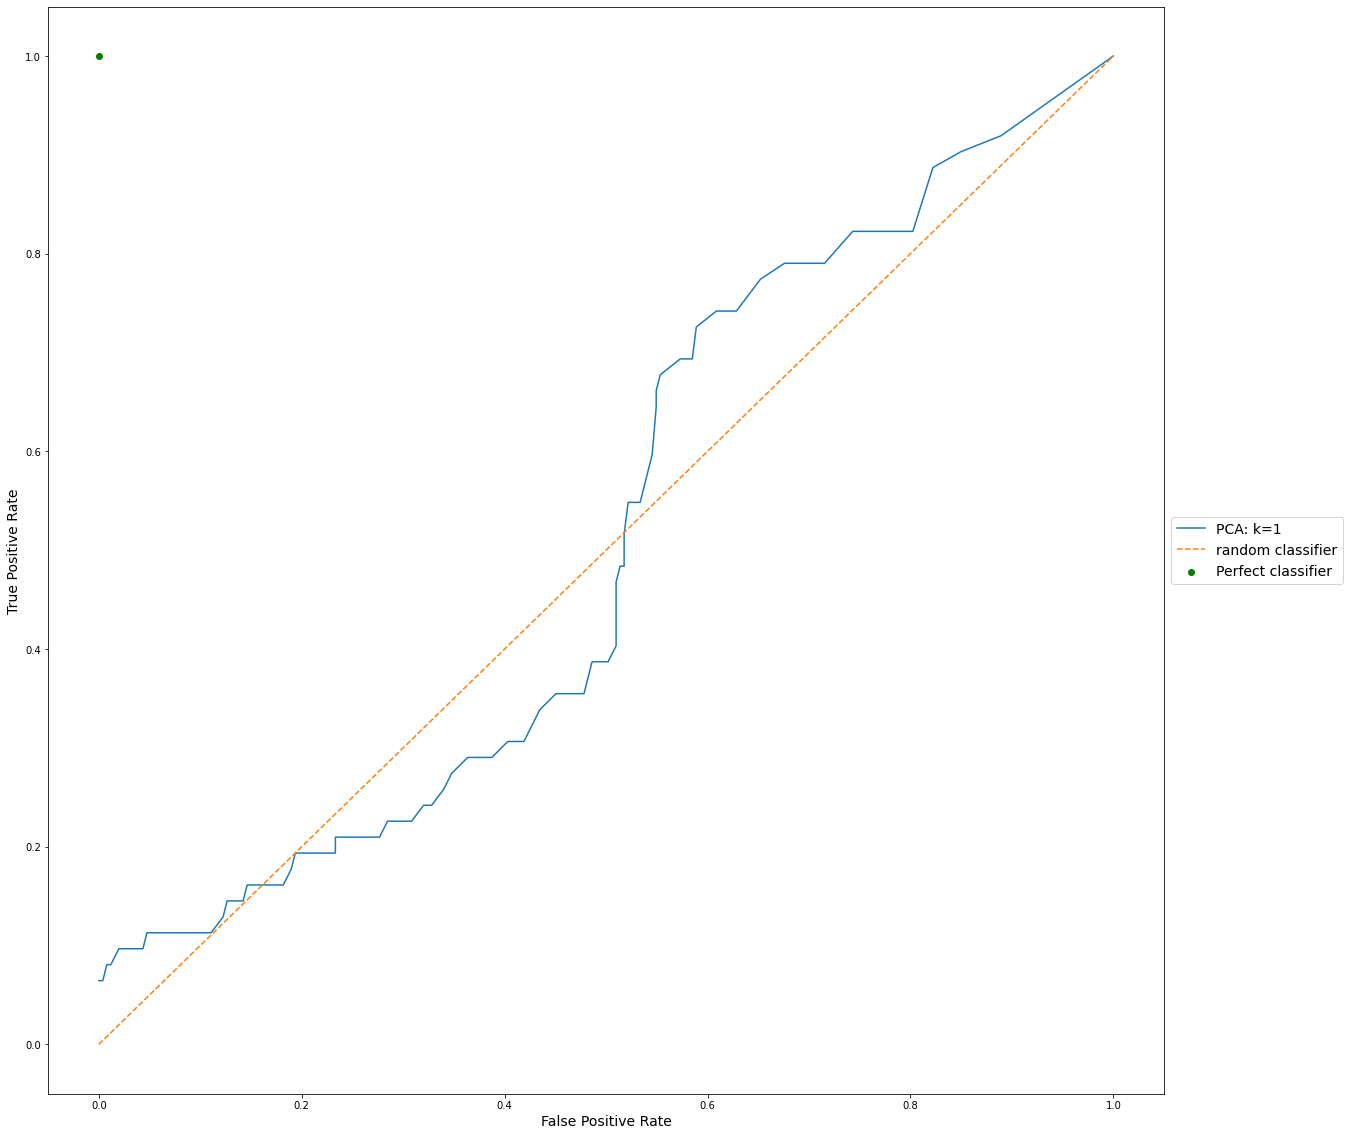

In [ ]:
# plot ROC of OutlierDetectorPCA
plot_ROC(clf_pca,X_train,y_train)

## <font size=5 color=#009999> Q4. k-PCA </font> <br>
</font>

Let us implement an outlier detector using <b>k-PCA</b>.
We can now leverage the work we did by defining a class in Q3: we "cheat" by <b>computing the features of the feature space</b> and then applying standard PCA on it.

We implemented most of the class, but there are some parts missing...

<div class="alert alert-warning">
    <b>[Remark]</b> We <b>could</b> implement kPCA without resorting to the explicit computation of the features $\phi(\mathbf{x}_i)$, but the implementation is a bit tricky...

This works here because the data set is not large, both in terms of input space (2-dimensional) and in the number of samples.
    
Remark that even with higher dimensional data set, we could simply restrict ourself to k' (principal) components, and computing the projection onto $\mathcal{S}_k$ with k << k'.
    
It would be interesting for you to take advantage of this to <i>actually see what features in the feature space look like</i>.
    
</div>

In [104]:
class OutlierDetectorKPCA(OutlierDetectorPCA):
    def __init__(self, param, k):
        """ ------------------------------------------------------------------------------
        Class constructor
        INPUT:
            - param: a dictionary containing the params of the kernel pca
            - k: the number of eigenvectors that we keep, or equivalently, the size of the
                 the eigen (sub)space.
        Example of the use of the constructor
            
            clf_kpca = OutlierDetectorKPCA(param={'kernel':'rbf', 'gamma':42}, k=1)
        ------------------------------------------------------------------------------ """
        OutlierDetectorPCA.__init__(self, k)  # we take advantage of the inheritance
        self.kpca = KernelPCA(fit_inverse_transform=False, remove_zero_eig=False)
        self.name = 'KPCA'
        self.params = param
        self.kpca.set_params(**param)

    def _predict_tau_ROC(self, X, tau):
        """ ------------------------------------------------------------------------------
        Companion function used to properly deal with the ROC of this inherited class
        ------------------------------------------------------------------------------ """                
        X_kpca = self.kpca.transform(X)
        return OutlierDetectorPCA.predict_tau(self, X_kpca, tau)        
        
    def fit(self, X, y):
        """ ------------------------------------------------------------------------------
        Fit the model to the true data
        INPUT: 
            - X: training data
            - y: label of training data
        OUTPUT:
            - the classifier
        ------------------------------------------------------------------------------ """
        X_kpca = self.kpca.fit_transform(X)
        print(f" old shape {X.shape} \n new shape {X_kpca.shape}")
        return OutlierDetectorPCA.fit(self, X_kpca, y)
        
    def get_label(self):
        label = OutlierDetectorPCA.get_label(self) + ", gamma={gamma}, kernel={kernel}".format(
            gamma=self.params['gamma'],
            kernel=self.params['kernel'])
        return label
        
    def predict(self, X):
        """ ------------------------------------------------------------------------------
        Predict the data using the fitted model
        INPUT: 
            - X: data
        OUTPUT:
            - y: predictions
        ------------------------------------------------------------------------------ """        
        # TODO
        X_kpca = self.kpca.transform(X)
        y_pred=  OutlierDetectorPCA.predict(self, X_kpca) 
        return y_pred
        

 old shape (500, 2) 
 new shape (500, 84)


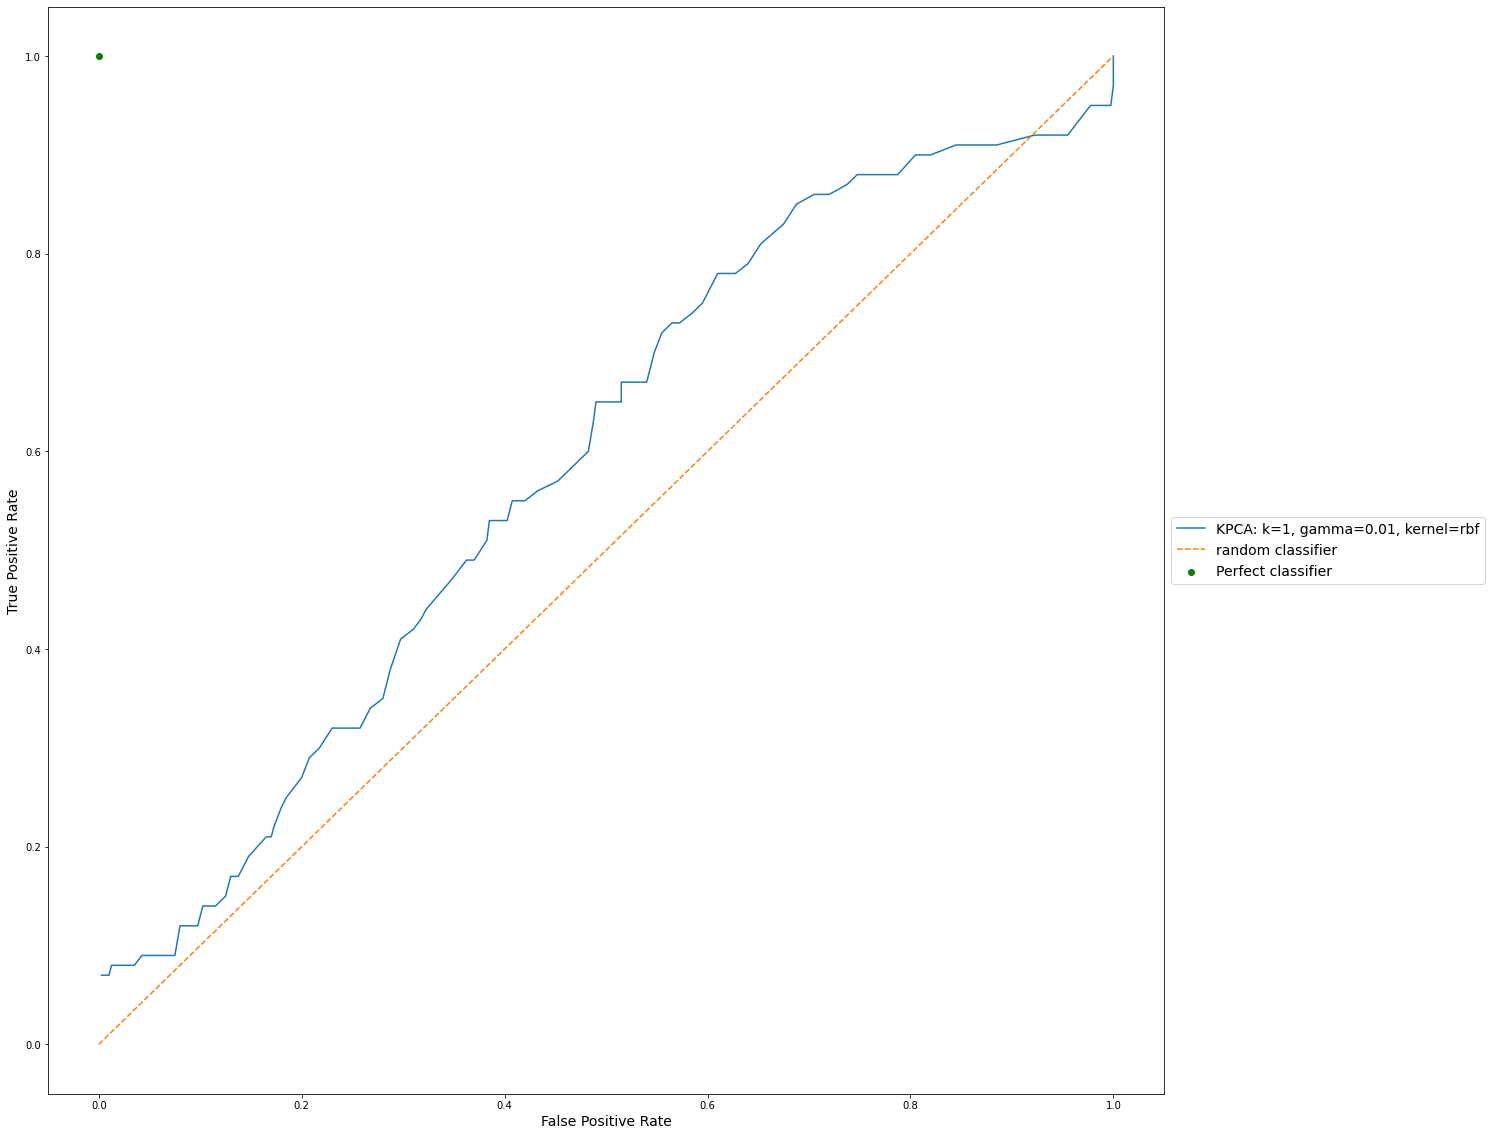

In [105]:
# plot ROC of OutlierDetectorPCA

k = 1
param = {"kernel":"rbf", "gamma":0.01}

clf_kpca = OutlierDetectorKPCA(param, k)
clf_kpca.fit(X, y)

plot_ROC(clf_kpca, X, y)



## <font size=5 color=#009999> Q5. Model selection </font> <br>
</font>

Perform your model selection: don't forget that you train your models on the train set, and tune the hyperparameter using the validation set.


 old shape (315, 2) 
 new shape (315, 80)


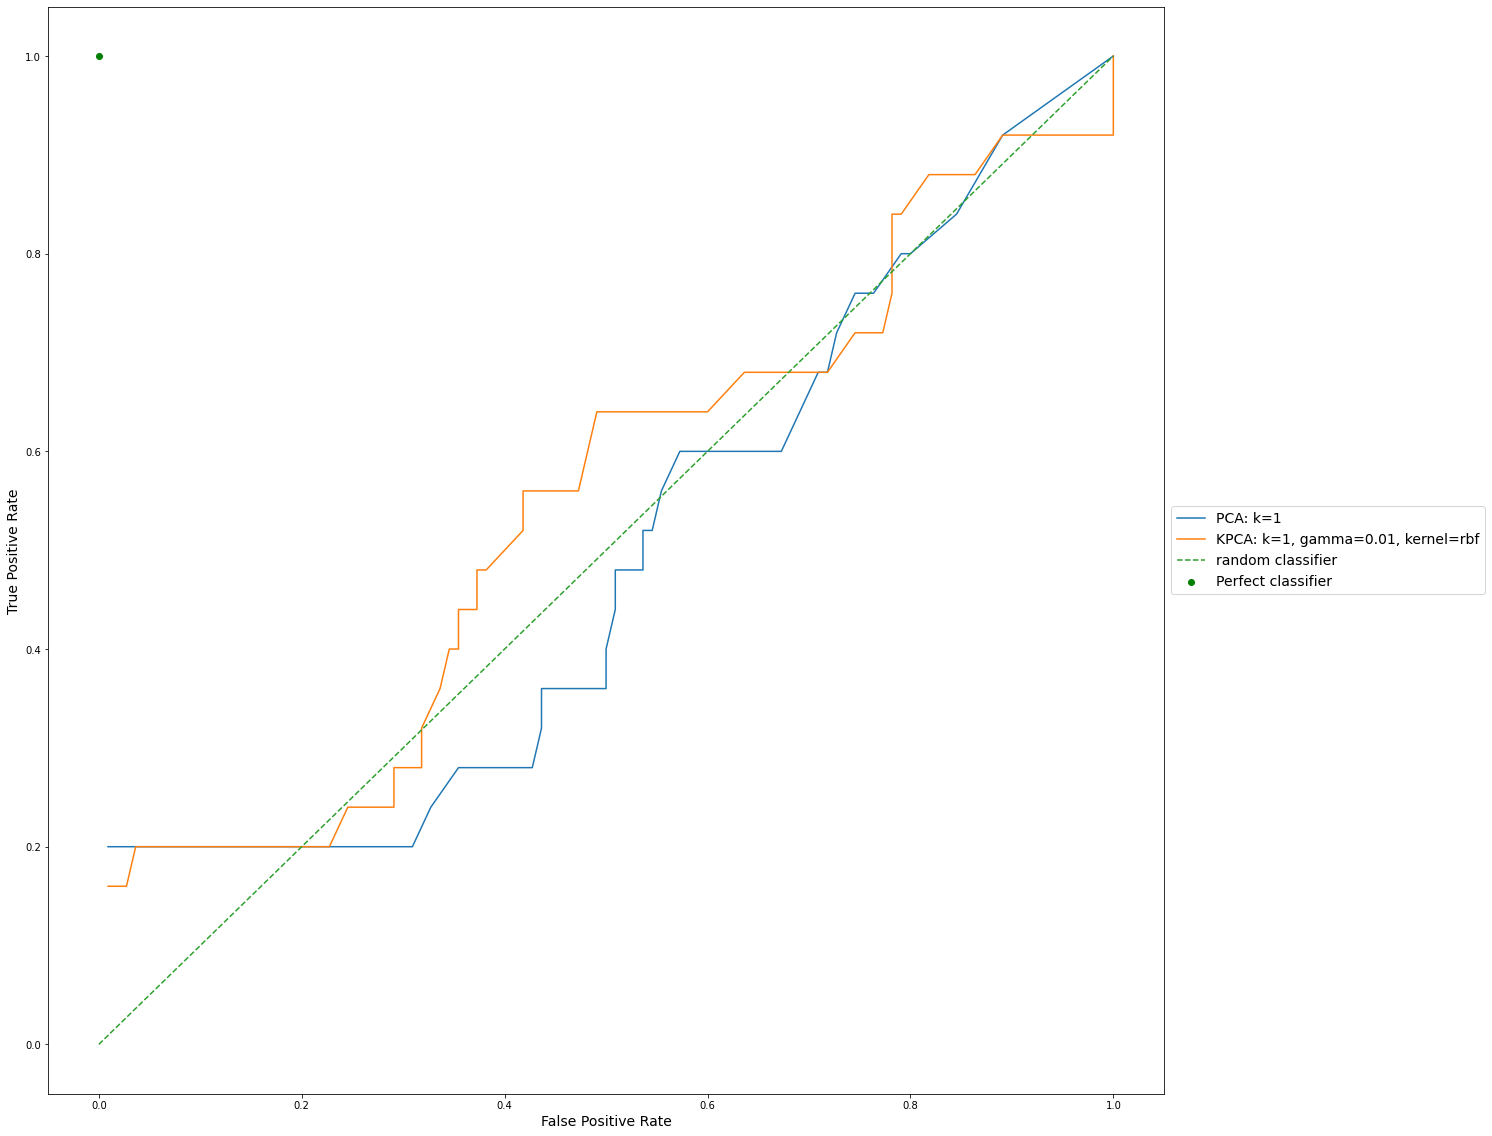

In [106]:
# COMPARE PCA AND KPCA with default values k=1 kernel "rbf" gamma=0.01
k = 1
gamma=0.01


classifs = [] 
clf_pca = OutlierDetectorPCA(1)
clf_pca.fit(X_train, y_train)
classifs.append(clf_pca)
param = {"kernel":"rbf", "gamma":gamma}
clf_kpca = OutlierDetectorKPCA(param, 1)
clf_kpca.fit(X_train, y_train)
classifs.append(clf_kpca)

# list of the model I want to compare

plot_ROC(classifs, X_val, y_val)

# PLOT SHOWS CLASSIFIER CLOSEST TO BEST IS KPCA

 old shape (315, 2) 
 new shape (315, 80)
 old shape (315, 2) 
 new shape (315, 80)
 old shape (315, 2) 
 new shape (315, 80)
 old shape (315, 2) 
 new shape (315, 80)


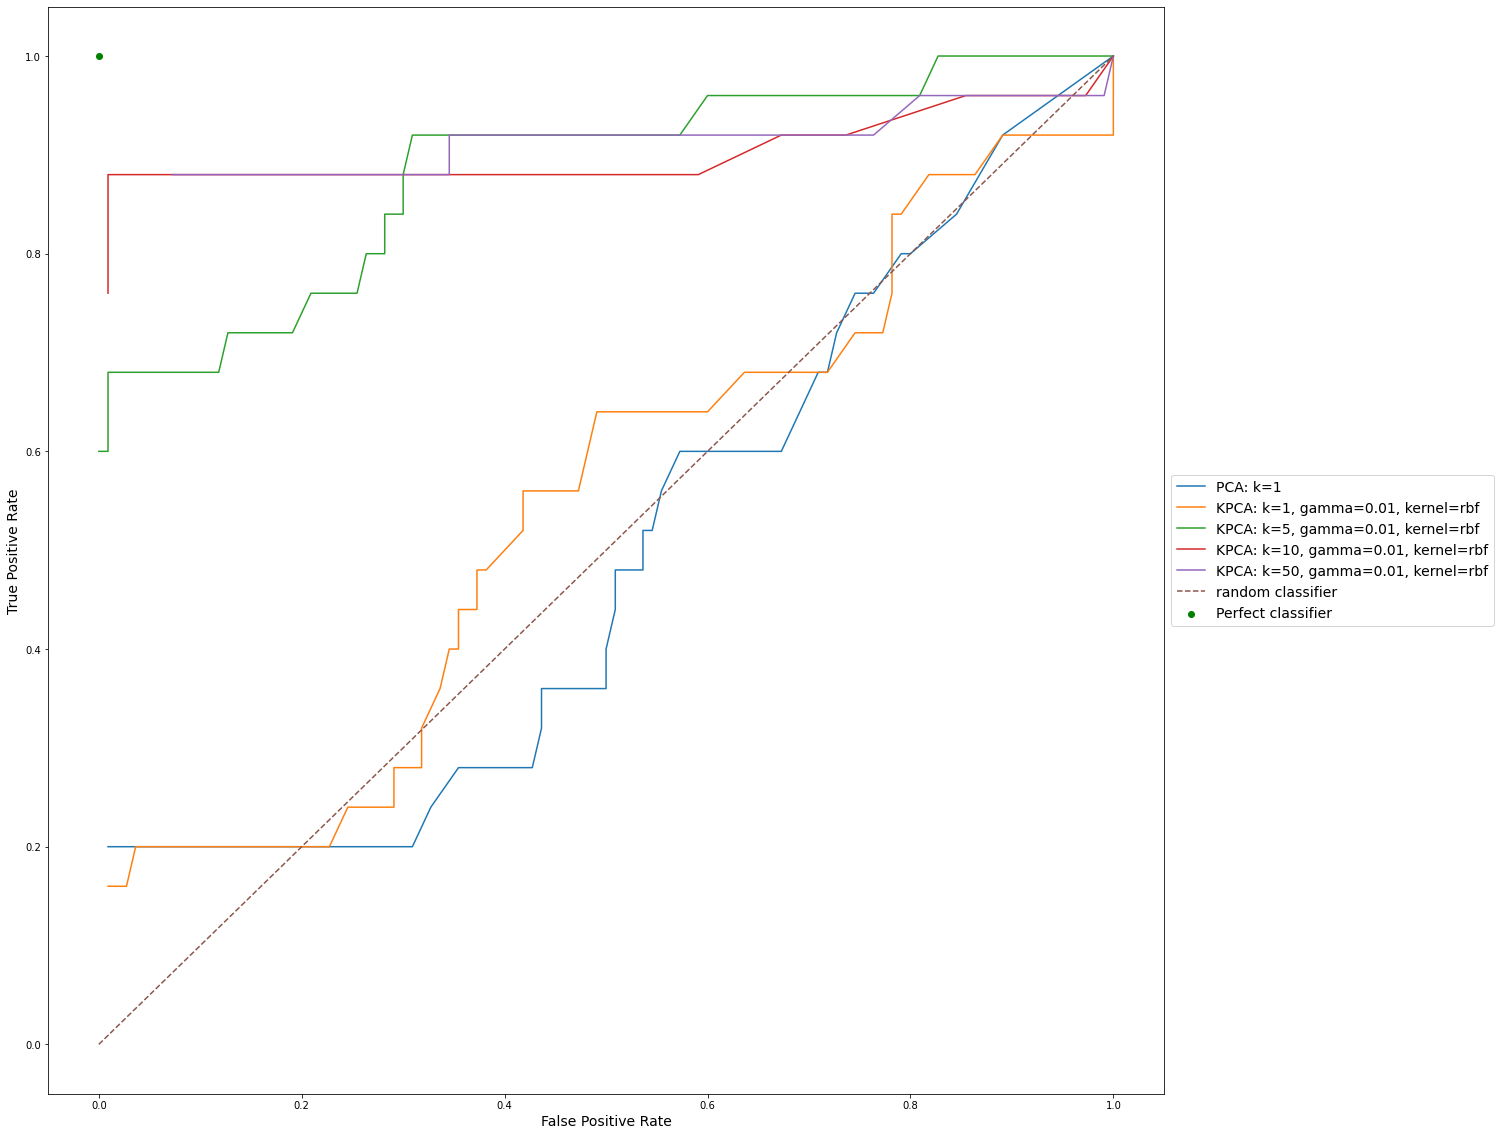

In [107]:
#COMPARE KPCA base on k value 
k = [1,5,10,50]
gamma=0.01

classifs = [] 
clf_pca = OutlierDetectorPCA(1)
clf_pca.fit(X_train, y_train)
classifs.append(clf_pca)
for i in k:
  param = {"kernel":"rbf", "gamma":gamma}
  clf_kpca = OutlierDetectorKPCA(param, i)
  clf_kpca.fit(X_train, y_train)
  classifs.append(clf_kpca)

# list of the model I want to compare

plot_ROC(classifs, X_val, y_val)

#PLOT SHOWS THAT CLOSEST CLASSIFIER TO BEST CLASSIFIER HAS K=5

 old shape (315, 2) 
 new shape (315, 33)
 old shape (315, 2) 
 new shape (315, 80)
 old shape (315, 2) 
 new shape (315, 314)
 old shape (315, 2) 
 new shape (315, 314)
 old shape (315, 2) 
 new shape (315, 314)


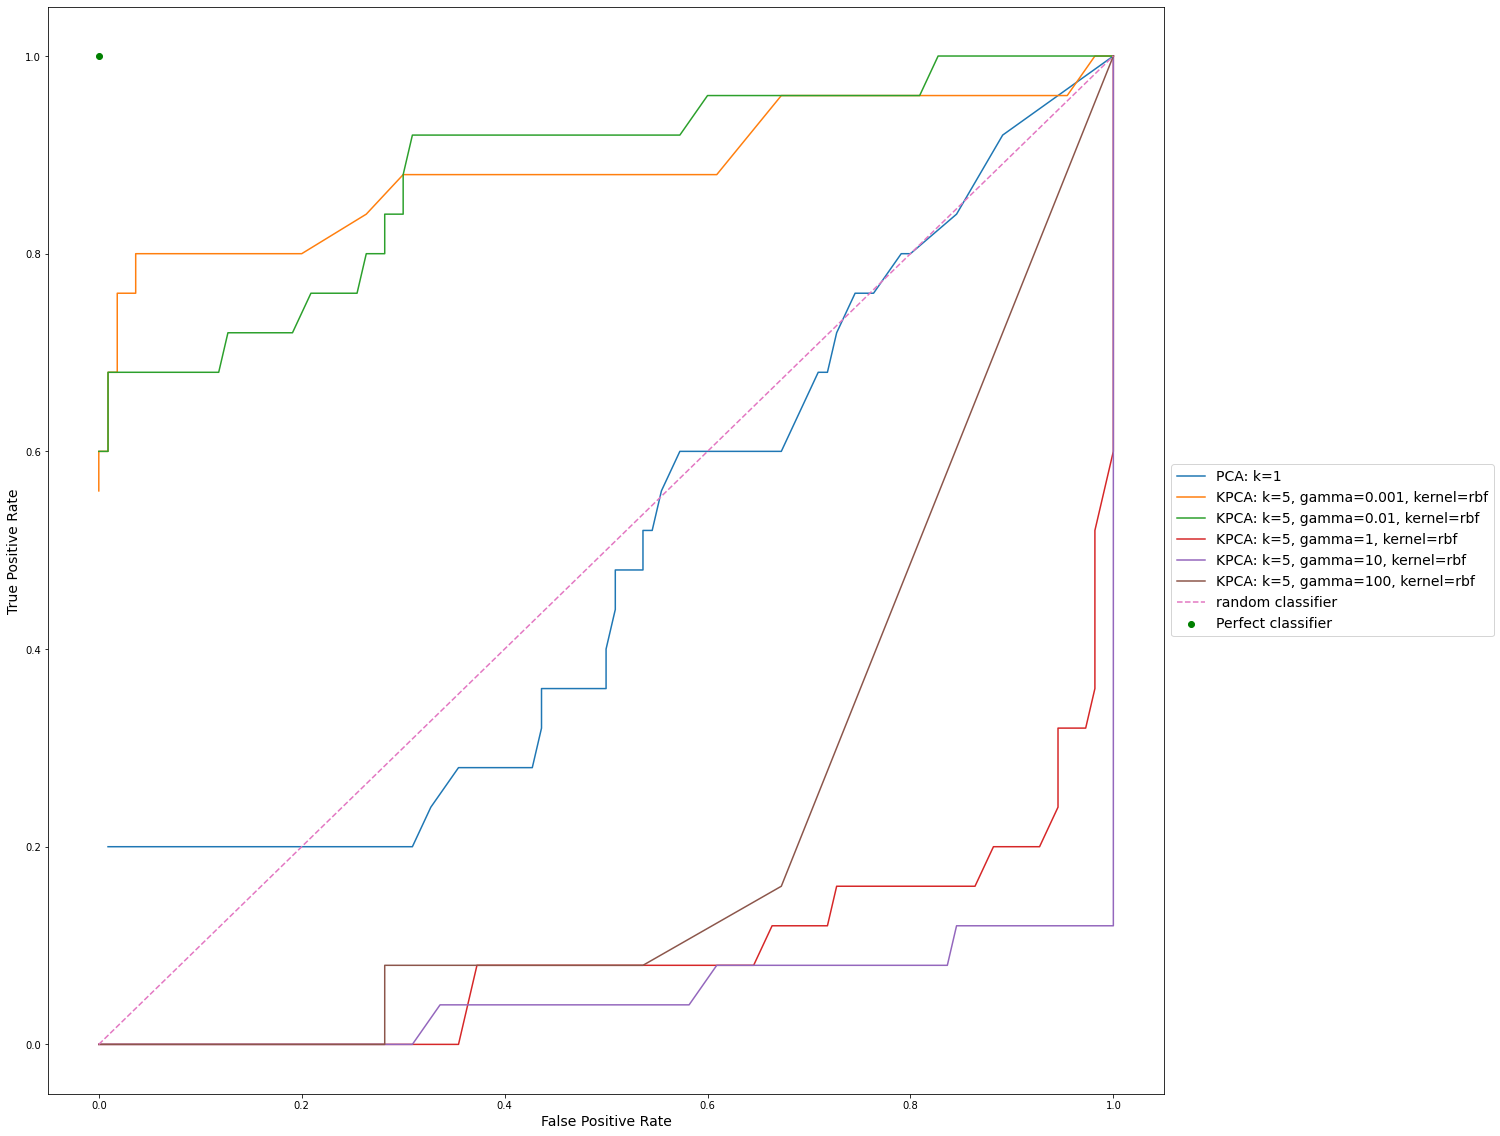

In [108]:
#COMPARE KPCA based on gamma value 
k =5 
gamma=[0.001,0.01,1,10,100]

classifs = [] 
clf_pca = OutlierDetectorPCA(1)
clf_pca.fit(X_train, y_train)
classifs.append(clf_pca)
for i in gamma:
  param = {"kernel":"rbf", "gamma":i}
  clf_kpca = OutlierDetectorKPCA(param, k)
  clf_kpca.fit(X_train, y_train)
  classifs.append(clf_kpca)

# list of the model I want to compare

plot_ROC(classifs, X_val, y_val)

#PLOT SHOWS THAT CLOSEST CLASSIFIER TO BEST CLASSIFIER HAS gamma=0.001

 old shape (315, 2) 
 new shape (315, 33)
 old shape (315, 2) 
 new shape (315, 9)


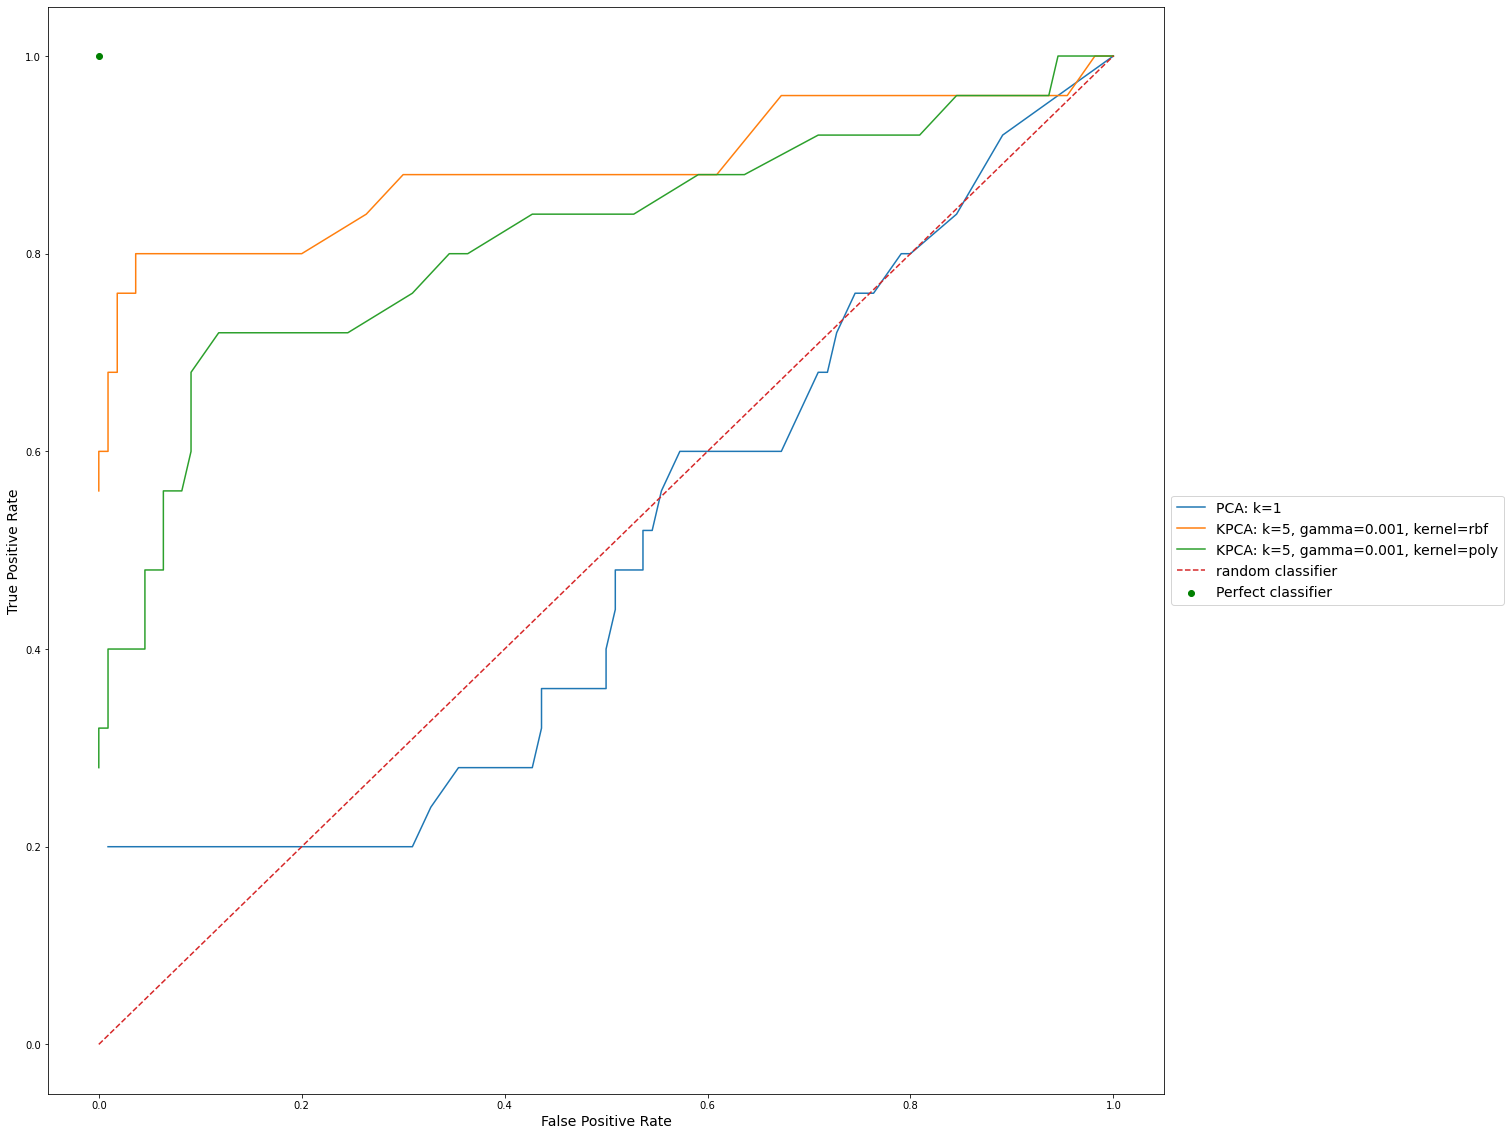

In [109]:
#COMPARE KPCA based on gamma value 
k =5 
gamma=0.001
kernel=['rbf','poly']

classifs = [] 
clf_pca = OutlierDetectorPCA(1)
clf_pca.fit(X_train, y_train)
classifs.append(clf_pca)
for i in kernel:
  param = {"kernel":i, "gamma":gamma}
  clf_kpca = OutlierDetectorKPCA(param, k)
  clf_kpca.fit(X_train, y_train)
  classifs.append(clf_kpca)

# list of the model I want to compare

plot_ROC(classifs, X_val, y_val)

#PLOT SHOWS THAT CLOSEST CLASSIFIER TO BEST CLASSIFIER HAS kernel=rbf

 old shape (315, 2) 
 new shape (315, 80)


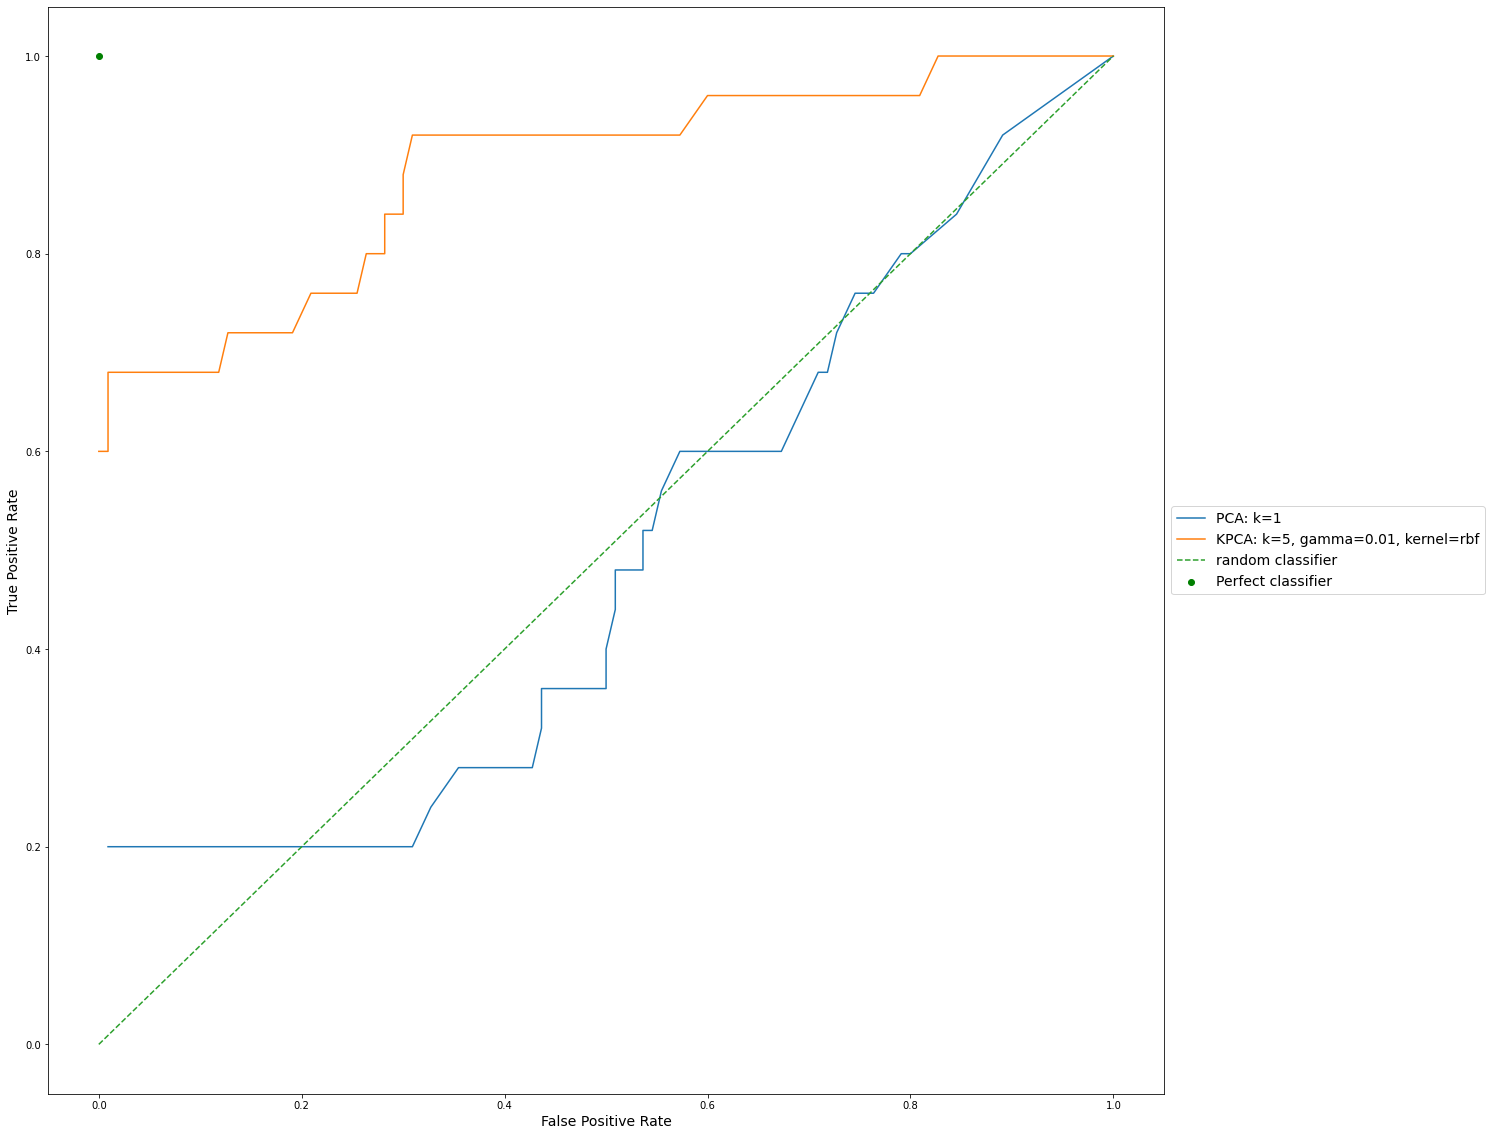

In [114]:
# COMPARE PCA AND best KPCA k=5, gamma=0.001, kernel="rbf" 
k = 5
gamma=0.01


classifs = [] 
clf_pca = OutlierDetectorPCA(1)
clf_pca.fit(X_train, y_train)
classifs.append(clf_pca)
param = {"kernel":"rbf", "gamma":gamma}
clf_kpca = OutlierDetectorKPCA(param, k)
clf_kpca.fit(X_train, y_train)
classifs.append(clf_kpca)

# list of the model I want to compare

plot_ROC(classifs, X_val, y_val)



## <font size=5 color=#009999> Q6. Analysis </font> <br>
</font>

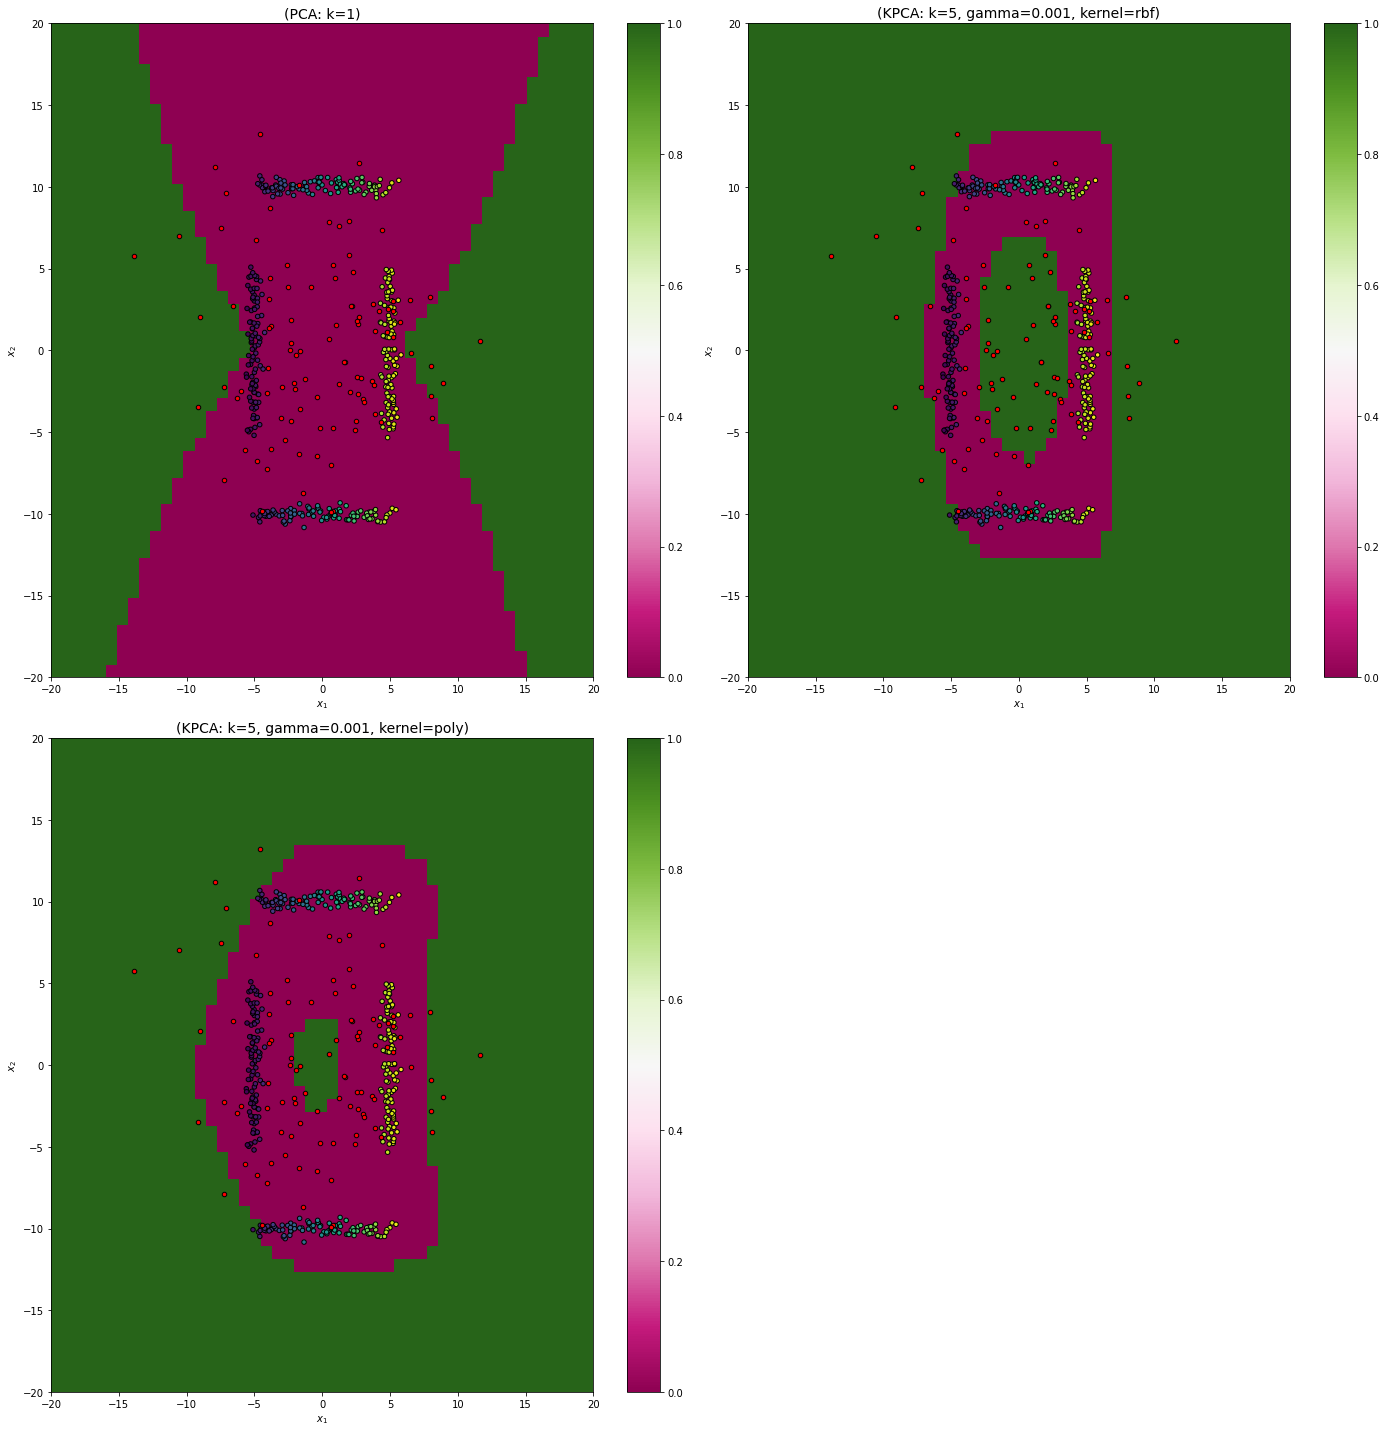

In [111]:
# check plot comparision on all data
plot_comparison_outlier_detector(classifs, X, y)

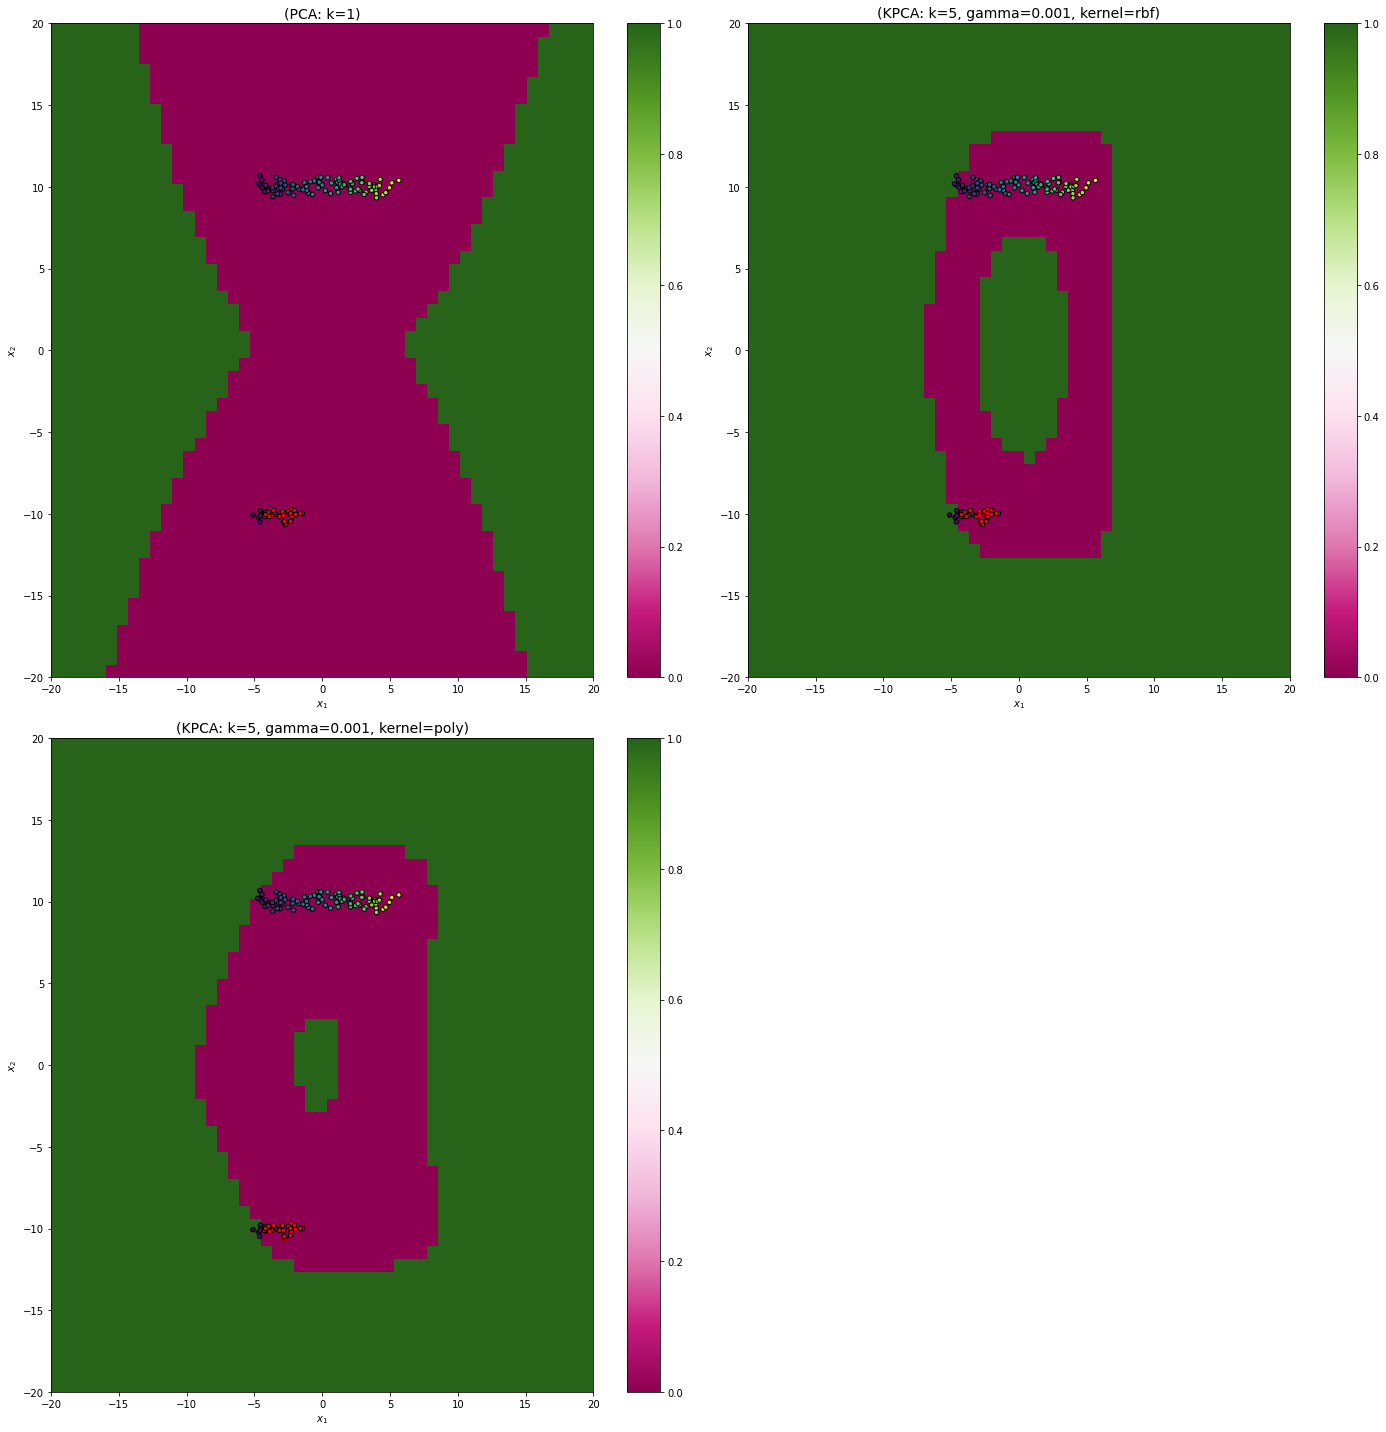

In [112]:
# check plot comparision on validation data
plot_comparison_outlier_detector(classifs, X_val, y_val)

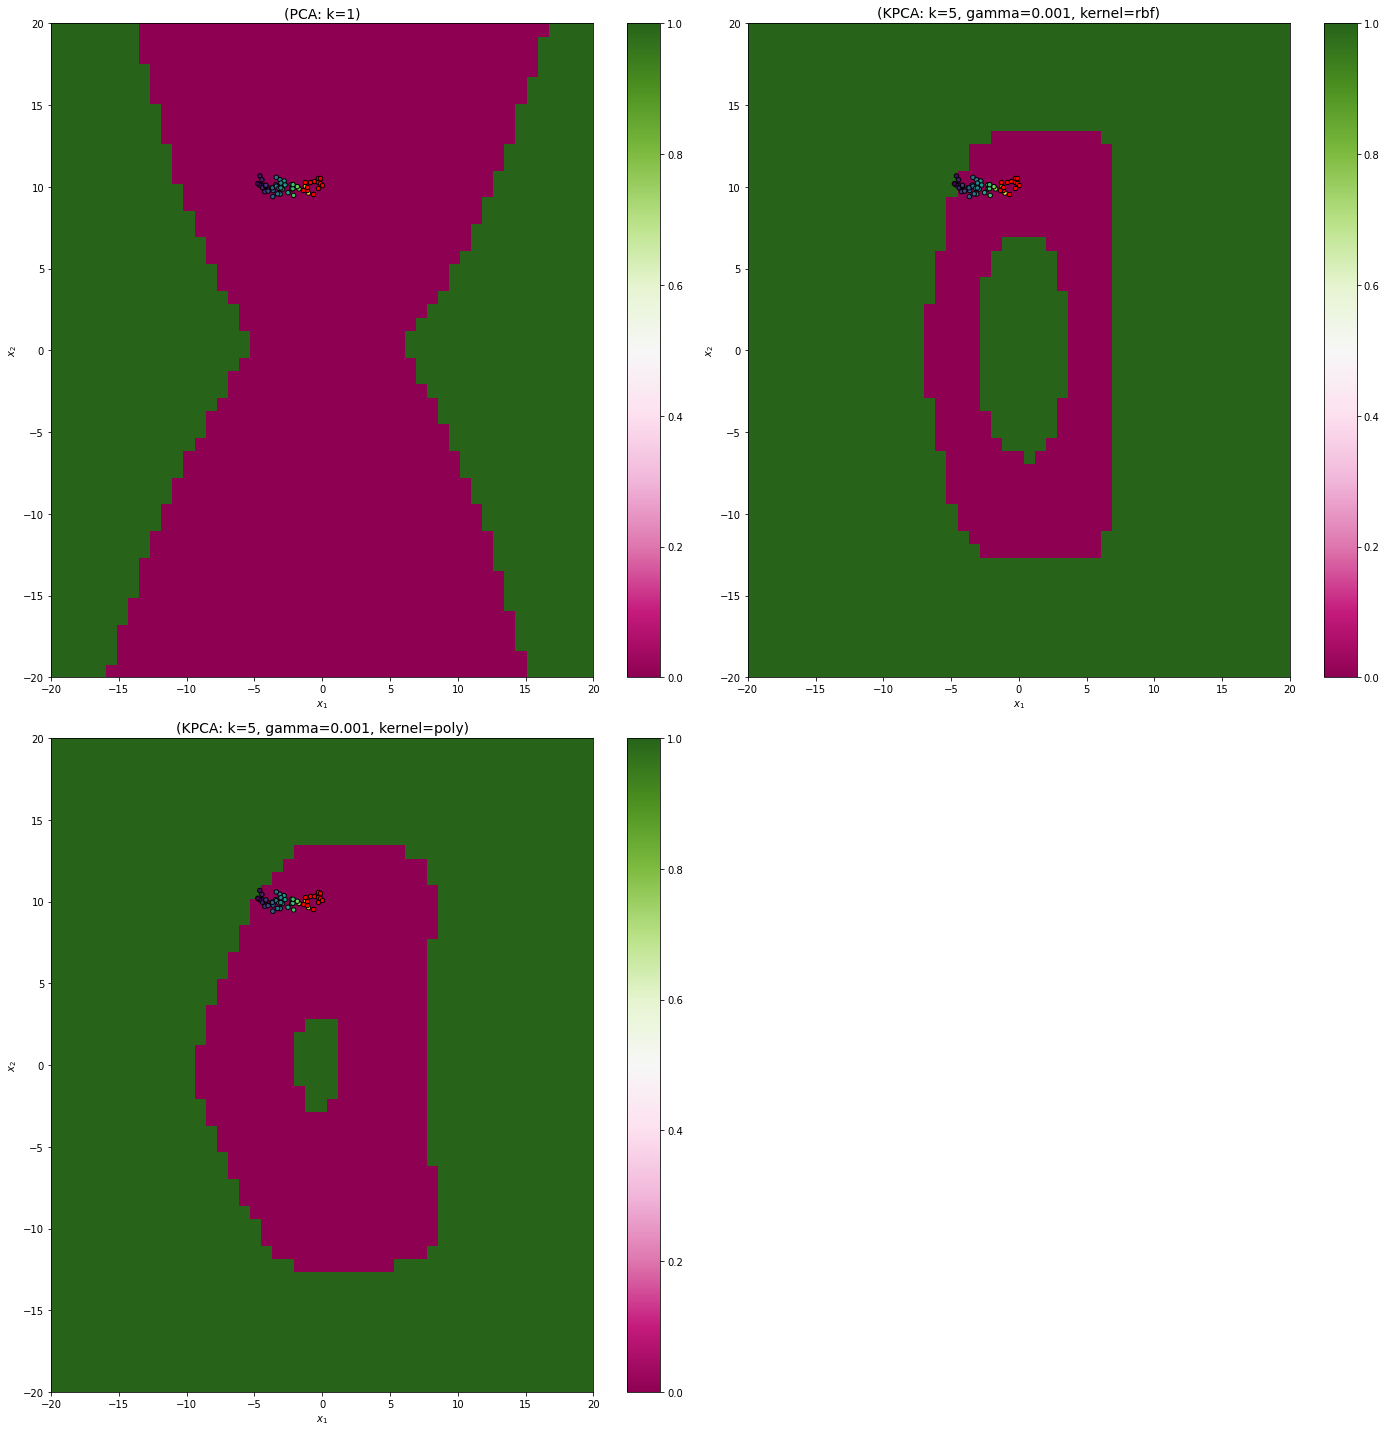

In [113]:
# check plot comparision on test data
plot_comparison_outlier_detector(classifs, X_test, y_test)